<a href="https://colab.research.google.com/github/Ahmet-Onder-Onlu/ML_Models/blob/main/sparkMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Veri setinin hazırlanması**

### **Kaggle api key üzerinden verinin çekilmesi ve analizi**

In [1]:
# Drive' a bağlantı sağlandı
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive üzerinde gerekli klasör yapıları oluşturuldu

In [2]:
#!mkdir /content/drive/MyDrive/sparkML

In [ ]:
#!mkdir /content/drive/MyDrive/sparkML/kaggle

In [7]:
#!mkdir /content/drive/MyDrive/sparkML/data

root yoluna .kaggle dizini yoksa eklendi ve kaggle.json dosyası drive üzerinden bu dizin altına kopyalandı. Böylece kaggle'dan veri seti çekmek için bu json dosyası kullanılacak.

In [3]:
import os
import shutil

# Ensure the .kaggle directory exists
os.makedirs("/root/.kaggle", exist_ok=True)

# Copy kaggle.json from Google Drive
shutil.copy("/content/drive/MyDrive/sparkML/kaggle/kaggle.json", "/root/.kaggle/kaggle.json")

# Set correct permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


Daha kalıcı olması adına ortam değişkeni olarak ayarlandı.

In [6]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/sparkML/kaggle"

In [4]:
# Kaggle kütüphanesi
!pip install kaggle

In [5]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                                       Car Price Dataset                                   135KB  2025-01-26 19:53:28           9847        137  1.0              
anandshaw2001/netflix-movies-and-tv-shows                      Netflix Movies and TV Shows                           1MB  2025-01-03 10:33:01          18570        467  1.0              
sgoutami/spotify-streaming-history                             Spotify Streaming History                             6MB  2025-01-25 05:14:49           1981         34  1.0              
samithsachidanandan/most-popular-1000-youtube-videos           Mo

In [8]:
# Yukarıdaki kaggle veri setleri arasından istediğimiz veri setinin çekilme işlemi
!kaggle datasets download -d camnugent/california-housing-prices

Dataset URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices
License(s): CC0-1.0
100% 400k/400k [00:00<00:00, 684kB/s]
100% 400k/400k [00:00<00:00, 683kB/s]


In [9]:
# İndirilen zip veri seti dosyasının drive cloud üzerine çıkarılması

import zipfile

with zipfile.ZipFile("california-housing-prices.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/sparkML/data/california-housing-prices-dataset")  # Extract to "dataset" folders

https://spark.apache.org/docs/latest/ml-classification-regression.html
(Dökümanın okunması işlemi)

In [39]:
# Dökümantasyonu okuyup gerekli görülen kütüphanelerin import edilme işleminin gerçekleştirilmesi

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, GeneralizedLinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler, Imputer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

İşlemlere başlamadan önce spark session oluşturuldu. Ve veri seti dataframe formatında okundu. Daha sonrasında veri seti analizi için satır sütun sayıları veri türleri, temel istatistiksel değerleri ve NoNe değer analizi yapıldı.

In [37]:
# Spark oturumunu başlat
spark = SparkSession.builder.appName("CaliforniaHousing").getOrCreate()

# CSV dosyasını Spark DataFrame olarak oku
df_housing = spark.read.csv("/content/drive/MyDrive/sparkML/data/california-housing-prices-dataset/housing.csv",
                            header=True, inferSchema=True)

# İlk birkaç satırı göster (Spark DataFrame'de .show() kullanılır)
df_housing.show(5)

# Veri setinin satır ve sütun sayısını öğren
print(f"Satır Sayısı: {df_housing.count()}, Sütun Sayısı: {len(df_housing.columns)}")

# Veri yapısını göster
df_housing.printSchema()

# Temel istatistikleri göster (describe metodu ile)
df_housing.describe().show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Boş değerler içeren sütunun dağılım grafiği çizildi ve biraz sağa çarpık olduğu tespit edildi. Dolayısıyla ortalama ile dolduramak yanıltıcı sonuç vereceğinden medyan kullanarak boş değerlerin doldurulması kararı alındı.

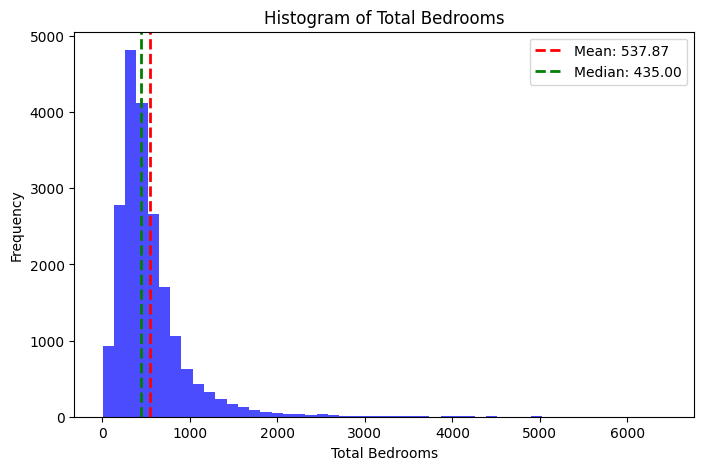

In [33]:
import matplotlib.pyplot as plt

# Spark DataFrame'i Pandas'a dönüştür (Pandas kütüphanesi fonksiyonları kullanabilmek için)
df_pandas = df_housing.select("total_bedrooms").toPandas()

# Histogramı çiz
plt.figure(figsize=(8, 5))
plt.hist(df_pandas["total_bedrooms"].dropna(), bins=50, color="blue", alpha=0.7)
plt.axvline(df_pandas["total_bedrooms"].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {df_pandas['total_bedrooms'].mean():.2f}")
plt.axvline(df_pandas["total_bedrooms"].median(), color='green', linestyle='dashed', linewidth=2, label=f"Median: {df_pandas['total_bedrooms'].median():.2f}")
plt.xlabel("Total Bedrooms")
plt.ylabel("Frequency")
plt.title("Histogram of Total Bedrooms")
plt.legend()
plt.show()

### Imputing, StringIndexer, VectorAssembler yöntemlerinin uygulanması

In [34]:
# Imputer (Eksik verileri median ile doldurma)
imputer = Imputer(inputCols=["total_bedrooms"], outputCols=["total_bedrooms_imputed"]).setStrategy("median")

# Eksik verileri doldur
df_housing = imputer.fit(df_housing).transform(df_housing)

# Doldurulan sütunu kontrol et
df_housing.select("total_bedrooms", "total_bedrooms_imputed").show(5)

+--------------+----------------------+
|total_bedrooms|total_bedrooms_imputed|
+--------------+----------------------+
|         129.0|                 129.0|
|        1106.0|                1106.0|
|         190.0|                 190.0|
|         235.0|                 235.0|
|         280.0|                 280.0|
+--------------+----------------------+
only showing top 5 rows



In [35]:
# StringIndexer ile "ocean_proximity" kategorik değişkenini sayısala çeviriyoruz
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")

# Dönüştürme işlemi
df_housing = indexer.fit(df_housing).transform(df_housing)

# Sonuçları göster
df_housing.select("ocean_proximity", "ocean_proximity_indexed").show(5)

+---------------+-----------------------+
|ocean_proximity|ocean_proximity_indexed|
+---------------+-----------------------+
|       NEAR BAY|                    3.0|
|       NEAR BAY|                    3.0|
|       NEAR BAY|                    3.0|
|       NEAR BAY|                    3.0|
|       NEAR BAY|                    3.0|
+---------------+-----------------------+
only showing top 5 rows



In [30]:
# Kullanılacak özellikler (label hariç tüm sayısal sütunlar)
feature_columns = ["longitude", "latitude", "housing_median_age", "total_rooms",
                   "total_bedrooms_imputed", "population", "households",
                   "median_income", "ocean_proximity_indexed"]

# VectorAssembler ile sütunları tek bir vektör haline getiriyoruz
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Dönüştürme işlemi
df_housing = vector_assembler.transform(df_housing)

# Sonuçları göster
df_housing.select("features").show(truncate=False, n=5)

+-----------------------------------------------------------+
|features                                                   |
+-----------------------------------------------------------+
|[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,3.0]    |
|[-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0]|
|[-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0]   |
|[-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0]   |
|[-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0]   |
+-----------------------------------------------------------+
only showing top 5 rows



## Pipeline Oluşturma ve Modellerin Test Edilip Değerlendirilmesi

Yaptığımız tüm process işlemlerinin bir pipeline altında toplanma  işlemi ve bu pipeline'ı kullanarak model üzerinde test edilecek. Tabiki veri setini baştan okuduk yukarıdaki işlemler ayrı ayrı gözlemlemek için oluşturuldu.

In [38]:
# Eksik değerleri doldurma (median veya mean seçebilirsiniz)
imputer = Imputer(inputCols=["total_bedrooms"], outputCols=["total_bedrooms_imputed"]).setStrategy("median")

# Kategorik değişkenleri sayısallaştırma (StringIndexer)
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")

# Kullanılacak özellikler (label hariç tüm sayısal sütunlar)
feature_columns = ["longitude", "latitude", "housing_median_age", "total_rooms",
                   "total_bedrooms_imputed", "population", "households",
                   "median_income", "ocean_proximity_indexed"]

# Özellikleri tek vektöre dönüştürme (VectorAssembler)
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Pipeline adımlarını belirleme
pipeline = Pipeline(stages=[imputer, indexer, vector_assembler])

# Pipeline'ı veriye uygula
df_transformed = pipeline.fit(df_housing).transform(df_housing)

# Sonucu incele
df_transformed.select("features", "median_house_value").show(5, truncate=False)

+-----------------------------------------------------------+------------------+
|features                                                   |median_house_value|
+-----------------------------------------------------------+------------------+
|[-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,3.0]    |452600.0          |
|[-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0]|358500.0          |
|[-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0]   |352100.0          |
|[-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0]   |341300.0          |
|[-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0]   |342200.0          |
+-----------------------------------------------------------+------------------+
only showing top 5 rows



GridSeach yöntemini kullanacağımız için modellerin ve parametrelerinin tanımlanması.

In [40]:
# Modelleri tanımla
models = {
    "LinearRegression": LinearRegression(featuresCol="features", labelCol="median_house_value"),
    "RandomForest": RandomForestRegressor(featuresCol="features", labelCol="median_house_value"),
    "GBTRegressor": GBTRegressor(featuresCol="features", labelCol="median_house_value"),
    "GeneralizedLinearRegression": GeneralizedLinearRegression(featuresCol="features", labelCol="median_house_value")
}

# Hiperparametre Grid’i oluşturdum
param_grids = {
    "LinearRegression": ParamGridBuilder()
        .addGrid(models["LinearRegression"].regParam, [0.1, 0.01])
        .addGrid(models["LinearRegression"].elasticNetParam, [0.0, 0.5, 1.0])
        .build(),

    "RandomForest": ParamGridBuilder()
        .addGrid(models["RandomForest"].numTrees, [10, 50])
        .addGrid(models["RandomForest"].maxDepth, [5, 10])
        .build(),

    "GBTRegressor": ParamGridBuilder()
        .addGrid(models["GBTRegressor"].maxIter, [10, 50])
        .addGrid(models["GBTRegressor"].maxDepth, [5, 10])
        .build(),

    "GeneralizedLinearRegression": ParamGridBuilder()
        .addGrid(models["GeneralizedLinearRegression"].regParam, [0.1, 0.01])
        .build()
}

Modellerin gridsearch mantığını kullanarak ayrıca crossvalidation yöntemini kullanmak için veri setimi 3 fold'a böldüm. Daha sonrasında her birinde en iyi modeli seçtim.

In [42]:
best_models = {}

for model_name, model in models.items():
    print(f"{model_name} modeli eğitiliyor...")

    # Evaluator (RMSE ile değerlendirme)
    evaluator = RegressionEvaluator(labelCol="median_house_value", metricName="rmse")

    # CrossValidator kullanımı
    crossval = CrossValidator(
        estimator=Pipeline(stages=[imputer, indexer, vector_assembler, model]),
        estimatorParamMaps=param_grids[model_name],
        evaluator=evaluator,
        numFolds=3  # 3-fold cross-validation
    )

    # Modeli eğit
    best_model = crossval.fit(df_housing)

    # En iyi modeli kaydet
    best_models[model_name] = best_model.bestModel

    print(f"{model_name} en iyi modeli seçildi!\n")


LinearRegression modeli eğitiliyor...
LinearRegression en iyi modeli seçildi!

RandomForest modeli eğitiliyor...
RandomForest en iyi modeli seçildi!

GBTRegressor modeli eğitiliyor...
GBTRegressor en iyi modeli seçildi!

GeneralizedLinearRegression modeli eğitiliyor...
GeneralizedLinearRegression en iyi modeli seçildi!



 Modellerin doğruluk metriklerinin analizini grafik bastırarak karşılaştırdım. Ve sonuç olarak en iyi modeli kayıt ettim.

                         Model          RMSE        R²
0             LinearRegression  69646.373196  0.635717
1                 RandomForest  49592.465758  0.815297
2                 GBTRegressor  47764.129978  0.828665
3  GeneralizedLinearRegression  69646.372817  0.635717


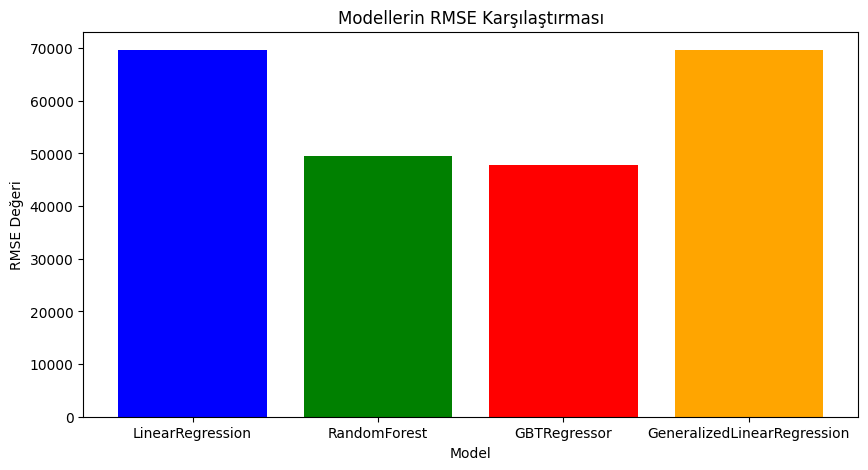

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Sonuçları kaydet
results = []

for model_name, model in best_models.items():
    predictions = model.transform(df_housing)
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
    r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
    results.append({"Model": model_name, "RMSE": rmse, "R²": r2})

# DataFrame'e çevir
df_results = pd.DataFrame(results)

# Tabloyu yazdır
print(df_results)

# Grafik Çiz
plt.figure(figsize=(10, 5))
plt.bar(df_results["Model"], df_results["RMSE"], color=["blue", "green", "red", "orange"])
plt.xlabel("Model")
plt.ylabel("RMSE Değeri")
plt.title("Modellerin RMSE Karşılaştırması")
plt.show()


In [46]:
# En iyi modeli seç
best_model = best_models["GBTRegressor"]

# Modeli kaydet
best_model.save("/content/drive/MyDrive/sparkML/GBT_model")
